In [16]:
# Cell 0 — Installs & imports
!pip install -q openpyxl plotly

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

In [17]:
# Cell 1 — Load dataset (change filename if needed)
path = "/content/Netflix Dataset.csv"
if os.path.exists(path):
    df = pd.read_csv(path)
else:
    from google.colab import files
    print("Upload the Netflix Dataset CSV file...")
    uploaded = files.upload()
    first = next(iter(uploaded))
    df = pd.read_csv(first)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (7789, 11)
Columns: ['Show_Id', 'Category', 'Title', 'Director', 'Cast', 'Country', 'Release_Date', 'Rating', 'Duration', 'Type', 'Description']


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [18]:
# Cell 2 — Normalize column names and quick info
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
print(df.columns.tolist())
print(df.info())
df.sample(3)

['show_id', 'category', 'title', 'director', 'cast', 'country', 'release_date', 'rating', 'duration', 'type', 'description']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7789 entries, 0 to 7788
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7789 non-null   object
 1   category      7789 non-null   object
 2   title         7789 non-null   object
 3   director      5401 non-null   object
 4   cast          7071 non-null   object
 5   country       7282 non-null   object
 6   release_date  7779 non-null   object
 7   rating        7782 non-null   object
 8   duration      7789 non-null   object
 9   type          7789 non-null   object
 10  description   7789 non-null   object
dtypes: object(11)
memory usage: 669.5+ KB
None


,show_id,category,title,director,cast,country,release_date,rating,duration,type,description
6874,s6873,Movie,The Silence of the Marsh,Marc Vigil,"Pedro Alonso, Nacho Fresneda, Carmina Barrios,...",Spain,"April 22, 2020",TV-MA,93 min,"International Movies, Thrillers","While researching corruption for his new book,..."
5586,s5586,Movie,SHOT! The Psycho-Spiritual Mantra of Rock,Barney Clay,Mick Rock,"United Kingdom, United States","August 10, 2017",TV-MA,98 min,"Documentaries, Music & Musicals",Aptly named iconic rock photographer Mick Rock...
368,s369,Movie,Ala Vaikunthapurramuloo,Trivikram Srinivas,"Allu Arjun, Pooja Hegde, Tabu, Sushanth, Nivet...",India,"February 27, 2020",TV-14,162 min,"Action & Adventure, Comedies, Dramas",After growing up enduring criticism from his f...


In [19]:
# Cell 3 — Parse release/date-added and extract year
date_cols = [c for c in ['release_date','date_added','added_date'] if c in df.columns]
if date_cols:
    df['release_date_parsed'] = pd.to_datetime(df[date_cols[0]], errors='coerce')
else:
    # try an explicit release_year column
    df['release_date_parsed'] = pd.NaT

# fallback: if release_year exists use that
if 'release_year' in df.columns:
    df['year'] = pd.to_numeric(df['release_year'], errors='coerce').astype('Int64')
else:
    df['year'] = df['release_date_parsed'].dt.year

# show span
print("Year range:", df['year'].min(), "to", df['year'].max())

Year range: 2008.0 to 2021.0


In [20]:
# Cell 4 — Fill common missing values with safe defaults
for c in ['director','cast','country','rating','type','category','duration','title']:
    if c in df.columns:
        df[c] = df[c].fillna("Unknown")

# normalize text fields
for c in ['type','category','rating']:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.title()

In [21]:
# Cell 5 — Main genre and exploded genre & country tables
# Ensure 'type' or 'listed_in' whichever your dataset uses
genre_col = 'type' if 'type' in df.columns else 'listed_in' if 'listed_in' in df.columns else None
if genre_col:
    df['main_genre'] = df[genre_col].astype(str).apply(lambda x: x.split(',')[0].strip() if x and x!='Unknown' else 'Unknown')
    # explode multi-genre
    df['genre_list'] = df[genre_col].astype(str).str.split(',').apply(lambda lst: [s.strip() for s in lst] if isinstance(lst,list) else ['Unknown'])
    df_genre = df.explode('genre_list').rename(columns={'genre_list':'genre'}).reset_index(drop=True)
else:
    df['main_genre'] = 'Unknown'
    df_genre = df.copy()

# countries explode
df['country_list'] = df['country'].astype(str).str.split(',').apply(lambda lst: [s.strip() for s in lst] if isinstance(lst,list) else ['Unknown'])
df_country = df.explode('country_list').rename(columns={'country_list':'country_exploded'}).reset_index(drop=True)

In [22]:
# Cell 6 — Parse duration (robust)
def parse_duration(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    # common patterns: "90 min", "1 Season", "2 Seasons"
    if 'min' in s.lower():
        try:
            return int(''.join(ch for ch in s if ch.isdigit()))
        except:
            return np.nan
    # seasons
    if 'season' in s.lower():
        try:
            return int(s.split()[0])
        except:
            return np.nan
    return np.nan

if 'duration' in df.columns:
    df['duration_num'] = df['duration'].apply(parse_duration)
else:
    df['duration_num'] = np.nan

In [23]:
# Cell 7 — Quick counts
if 'category' in df.columns:
    print("Category counts:\n", df['category'].value_counts())
else:
    print("No 'category' column found. Use 'type' or create mapping.")

print("\nTop 10 countries (exploded):")
print(df_country['country_exploded'].value_counts().head(10))

Category counts:
 category
Movie      5379
Tv Show    2410
Name: count, dtype: int64

Top 10 countries (exploded):
country_exploded
United States     3298
India              990
United Kingdom     723
Unknown            507
Canada             412
France             349
Japan              287
Spain              215
South Korea        212
Germany            199
Name: count, dtype: int64


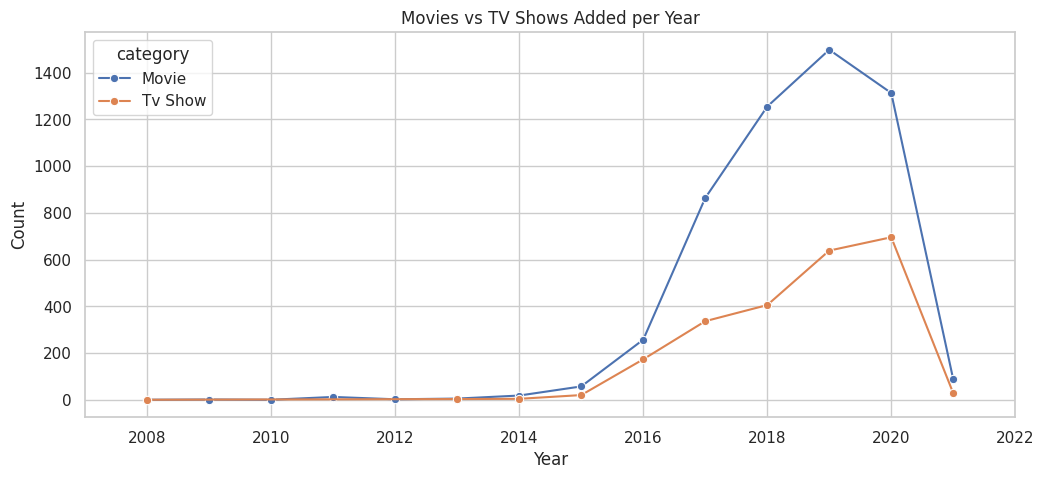

In [24]:
# Cell 8 — Movies vs TV Shows per year
type_col = 'category' if 'category' in df.columns else 'type' if 'type' in df.columns else None
if type_col and 'year' in df.columns:
    trend = df.groupby(['year', type_col]).size().reset_index(name='count')
    plt.figure(figsize=(12,5))
    sns.lineplot(data=trend, x='year', y='count', hue=type_col, marker='o')
    plt.title("Movies vs TV Shows Added per Year")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.xlim(trend['year'].min()-1, trend['year'].max()+1)
    plt.show()
else:
    print("Missing columns for trend plot.")

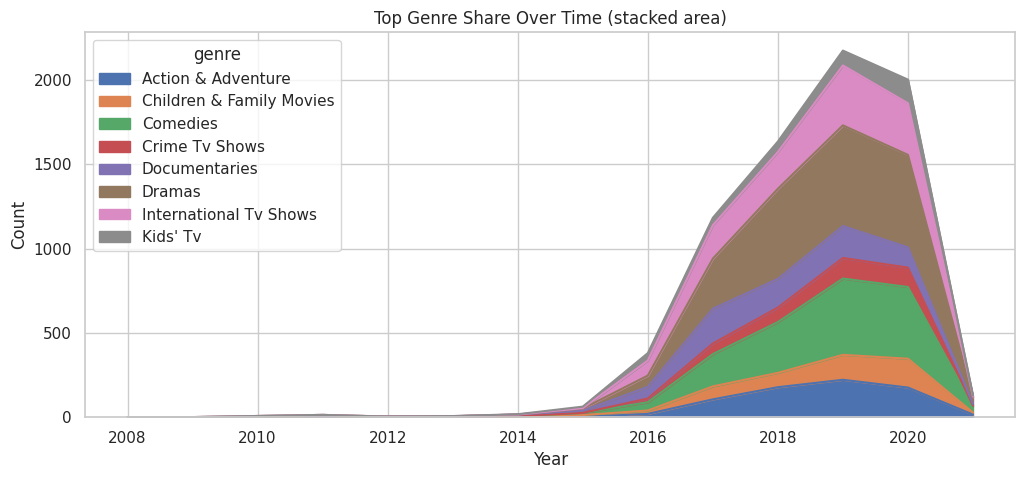

In [25]:
# Cell 9 — Top genres and their trends
top_genres = df['main_genre'].value_counts().head(8).index.tolist()
genre_trends = df_genre[df_genre['genre'].isin(top_genres)].groupby(['year','genre']).size().reset_index(name='count')
if not genre_trends.empty:
    pivot = genre_trends.pivot(index='year', columns='genre', values='count').fillna(0)
    pivot.plot(kind='area', stacked=True, figsize=(12,5))
    plt.title("Top Genre Share Over Time (stacked area)")
    plt.ylabel("Count")
    plt.xlabel("Year")
    plt.show()
else:
    print("No genre trend data.")

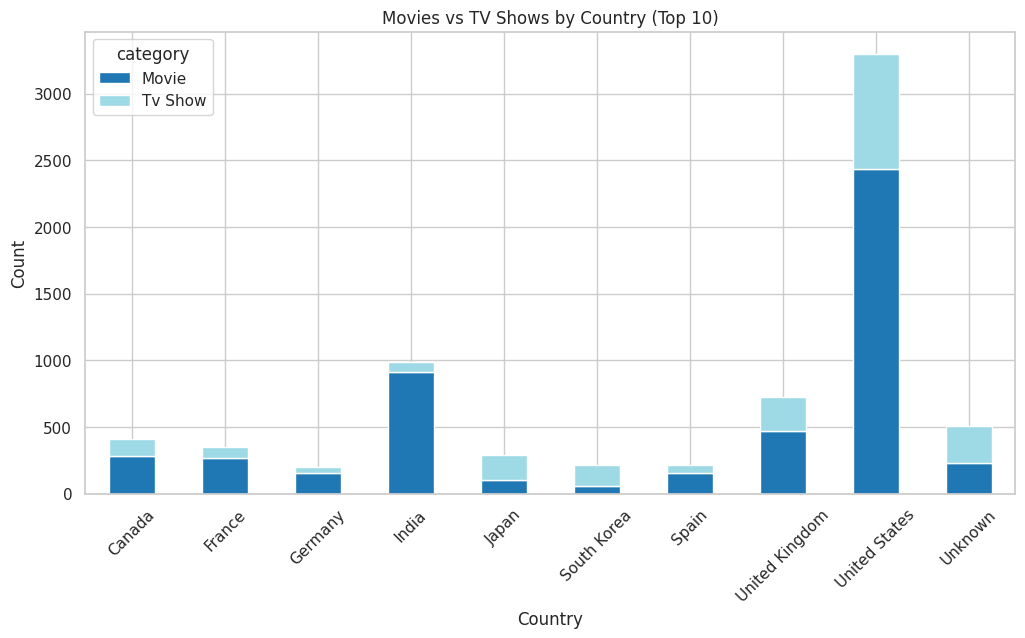

In [26]:
# Cell 10 — Movies vs TV Shows by top countries
top_countries = df_country['country_exploded'].value_counts().head(10).index
country_subset = df_country[df_country['country_exploded'].isin(top_countries)]
if type_col:
    stacked = country_subset.groupby(['country_exploded', type_col]).size().unstack(fill_value=0)
    stacked.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')
    plt.title("Movies vs TV Shows by Country (Top 10)")
    plt.xlabel("Country")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Type/category missing for stacked country plot.")

In [33]:
# Cell 11 — Choropleth of content counts by country (uses exploded countries)
country_counts = df_country['country_exploded'].value_counts().reset_index()
country_counts.columns = ['country','count']
# small cleaning for common mismatches
country_counts['country'] = country_counts['country'].replace({'United States Of America':'United States',
                                                               'Usa':'United States',
                                                               'Uk':'United Kingdom'})
fig = px.choropleth(country_counts, locations='country', locationmode='country names',
                    color='count', hover_name='country', title='Titles by Country')
fig.show()

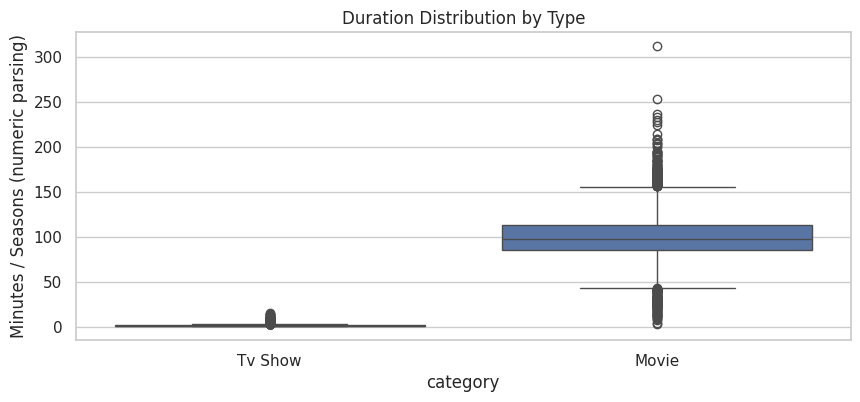

In [28]:
# Cell 12 — Duration analysis: movies minutes and seasons for shows
if 'duration_num' in df.columns:
    # separate movies vs shows if type_col exists
    if type_col:
        plt.figure(figsize=(10,4))
        sns.boxplot(data=df[df['duration_num'].notna()], x=type_col, y='duration_num')
        plt.title("Duration Distribution by Type")
        plt.ylabel("Minutes / Seasons (numeric parsing)")
        plt.show()
    else:
        sns.histplot(df['duration_num'].dropna(), kde=True)
        plt.title("Duration distribution (parsed numeric)")
        plt.show()

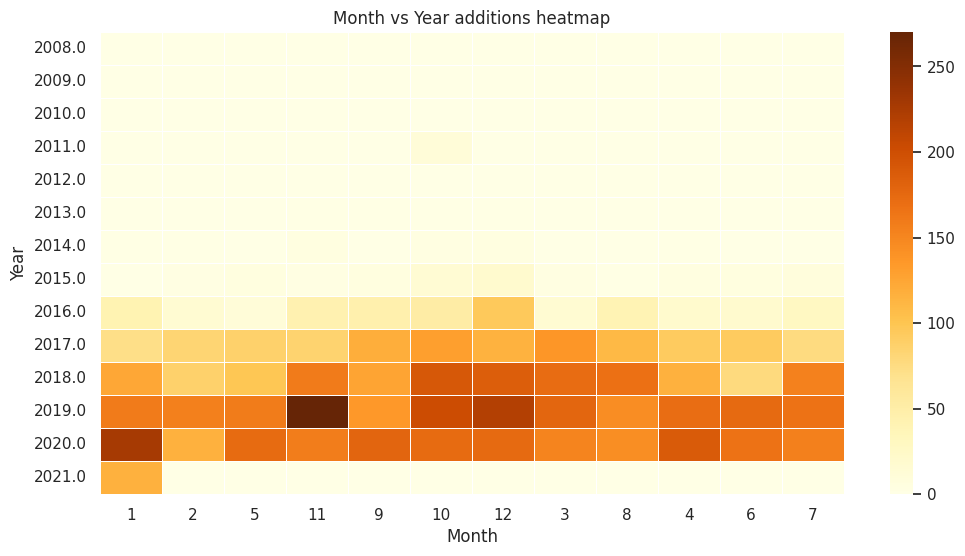

In [29]:
# Cell 13 — Month vs Year heatmap of additions (if date parsed)
if 'release_date_parsed' in df.columns:
    df['month'] = df['release_date_parsed'].dt.month.fillna(0).astype(int)
    heat = df.groupby(['year','month']).size().unstack(fill_value=0)
    plt.figure(figsize=(12,6))
    sns.heatmap(heat, cmap='YlOrBr', linewidths=.5)
    plt.title("Month vs Year additions heatmap")
    plt.xlabel("Month")
    plt.ylabel("Year")
    plt.show()

In [30]:
# Cell 14 — Top directors and cast frequency
if 'director' in df.columns:
    print("Top 10 directors:\n", df['director'].value_counts().head(10))
if 'cast' in df.columns:
    # explode cast members
    df['cast_list'] = df['cast'].astype(str).str.split(',').apply(lambda lst: [s.strip() for s in lst] if isinstance(lst,list) else [])
    cast_exp = df.explode('cast_list')
    print("Top 10 cast members:\n", cast_exp['cast_list'].value_counts().head(10))

Top 10 directors:
 director
Unknown                   2388
Raúl Campos, Jan Suter      18
Marcus Raboy                16
Jay Karas                   14
Cathy Garcia-Molina         13
Jay Chapman                 12
Youssef Chahine             12
Martin Scorsese             12
Steven Spielberg            10
David Dhawan                 9
Name: count, dtype: int64
Top 10 cast members:
 cast_list
Unknown             718
Anupam Kher          42
Shah Rukh Khan       35
Naseeruddin Shah     30
Om Puri              30
Takahiro Sakurai     29
Akshay Kumar         29
Yuki Kaji            27
Amitabh Bachchan     27
Paresh Rawal         27
Name: count, dtype: int64


In [31]:
# Cell 15 — Save cleaned CSVs and summary tables
out = "/content/netflix_outputs"
os.makedirs(out, exist_ok=True)
df.to_csv(os.path.join(out, "netflix_cleaned.csv"), index=False)
df_genre.to_csv(os.path.join(out, "netflix_genre_exploded.csv"), index=False)
df_country.to_csv(os.path.join(out, "netflix_country_exploded.csv"), index=False)

# sample summary tables
if 'year' in df.columns:
    df.groupby('year').size().to_csv(os.path.join(out,"counts_by_year.csv"))
if 'main_genre' in df.columns:
    df['main_genre'].value_counts().to_csv(os.path.join(out,"top_genres.csv"))

print("Saved outputs to", out)

Saved outputs to /content/netflix_outputs


In [32]:
# Cell 16 — Checklist
print("Done:")
print("- Data loaded and normalized")
print("- Genres and countries exploded for analysis")
print("- Duration parsed and basic EDA plotted")
print("- Outputs saved to /content/netflix_outputs")

# Next suggestions:
print("\nNext: (A) run statistical trend tests, (B) cluster titles by genre, (C) build small forecast for yearly additions.")

Done:
- Data loaded and normalized
- Genres and countries exploded for analysis
- Duration parsed and basic EDA plotted
- Outputs saved to /content/netflix_outputs

Next: (A) run statistical trend tests, (B) cluster titles by genre, (C) build small forecast for yearly additions.
